In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!



Stats of batch 5:
Samples: 10000
Label Counts: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}
First 20 Labels: [1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8]

Example of Image 9999:
Image - Min Value: 4 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


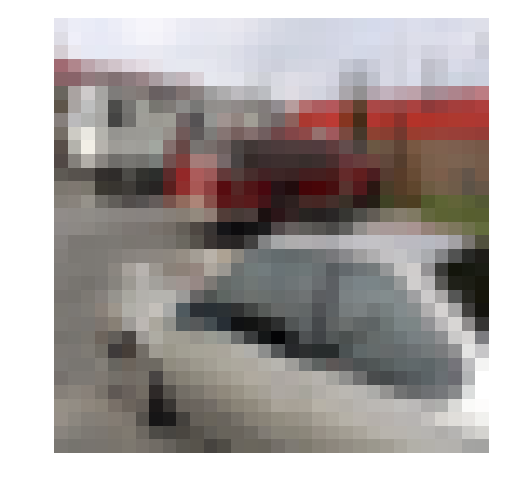

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 5
sample_id = 9999
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [3]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    x = x.astype('float32')
    x /= 255
    return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_normalize(normalize)

Tests Passed


In [4]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    labels = []
    for label in x:
        one_hot = np.array([int(i == label) for i in range(10)])
        labels.append(one_hot)
    return np.array(labels)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_one_hot_encode(one_hot_encode)

Tests Passed


In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Checkpoint

In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle
import problem_unittests as tests
import helper

import numpy as np

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [2]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


In [3]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    batch_size = None
    img_hgt = image_shape[0]
    img_wdt = image_shape[1]
    img_dpt = image_shape[2]

    x = tf.placeholder(
        tf.float32,
        name='x',
        shape=[batch_size, img_hgt, img_wdt, img_dpt]
    )
    return x


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    y = tf.placeholder(tf.float32, [None, n_classes], name='y')
    return y


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    return keep_prob


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


In [4]:
def conv_net(x, keep_prob, is_train=True):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    #32x32x3
    model = tf.layers.conv2d(x, 64, 4, strides=2, padding='same', activation=tf.nn.relu)
    
    #16x16x64
    model = tf.layers.conv2d(model, 128, 4, strides=1, padding='same', activation=tf.nn.relu)
    model = tf.nn.dropout(model, keep_prob)
    
    #16x16x128
    model = tf.layers.conv2d(model, 256, 4, strides=2, padding='same', activation=None)
    model = tf.nn.relu(model)
    
    #8x8x256
    model = tf.layers.conv2d(model, 384, 4, strides=1, padding='same', activation=tf.nn.relu)
    model = tf.nn.dropout(model, keep_prob)
    
    #8x8x256
    model = tf.layers.conv2d(model, 512, 4, strides=2, padding='same', activation=tf.nn.relu)
    
    #4x4x384
    model = tf.reshape(model, (-1, 4*4*512))
    
    model = tf.layers.dense(model, 512, activation=tf.nn.relu)
    model = tf.nn.dropout(model, keep_prob)
    
    model = tf.layers.dense(model, 128, activation=tf.nn.relu)
    
    logits = tf.layers.dense(model, 10, activation=None)
    
    # TODO: return output
    return logits


In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
is_training = tf.placeholder(tf.bool, name='is_training')
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob, is_training)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


In [7]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer, feed_dict={
        x: feature_batch,
        y: label_batch,
        keep_prob: keep_probability,
        is_training: True
    })


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_train_nn(train_neural_network)

Tests Passed


In [8]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    loss = session.run(cost, feed_dict={
        x: feature_batch,
        y: label_batch,
        keep_prob: 1.,
        is_training:False
    })
    valid_acc = session.run(accuracy, feed_dict={
        x: valid_features,
        y: valid_labels,
        keep_prob: 1.,
        is_training:False
    })

    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(
        loss,
        valid_acc))

In [9]:
# TODO: Tune Parameters
epochs = 70
batch_size = 128
keep_probability = 0.5

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from datetime import datetime
save_model_path = './image_classification'

print('Training...')
start = datetime.now()

with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())

    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        if epoch in (30, 40, 50, 60):
            resp = input('Keep training? [y/n]')
            if resp == 'n':
                break

        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
    
    # Total time
    print('Total training time {}'.format(datetime.now() - start))    

    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     2.0818 Validation Accuracy: 0.320400
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.7041 Validation Accuracy: 0.390600
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.3295 Validation Accuracy: 0.431800
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.6112 Validation Accuracy: 0.460800
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.4814 Validation Accuracy: 0.496600
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.4602 Validation Accuracy: 0.526000
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.2609 Validation Accuracy: 0.515400
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.0613 Validation Accuracy: 0.536200
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.2434 Validation Accuracy: 0.552000
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.2132 Validation Accuracy: 0.584800
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.1866 Validation Accuracy: 0.574800
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.0405 Validation Accuracy: 0.552600
Epoch  3, CIFAR-10 Batch 3:  Loss:     0.7823 Validation Accuracy: 0.599000


Epoch 22, CIFAR-10 Batch 3:  Loss:     0.0397 Validation Accuracy: 0.752800
Epoch 22, CIFAR-10 Batch 4:  Loss:     0.0772 Validation Accuracy: 0.753800
Epoch 22, CIFAR-10 Batch 5:  Loss:     0.0323 Validation Accuracy: 0.772400
Epoch 23, CIFAR-10 Batch 1:  Loss:     0.0704 Validation Accuracy: 0.757200
Epoch 23, CIFAR-10 Batch 2:  Loss:     0.0564 Validation Accuracy: 0.744400
Epoch 23, CIFAR-10 Batch 3:  Loss:     0.0432 Validation Accuracy: 0.759800
Epoch 23, CIFAR-10 Batch 4:  Loss:     0.0516 Validation Accuracy: 0.760000
Epoch 23, CIFAR-10 Batch 5:  Loss:     0.0345 Validation Accuracy: 0.761200
Epoch 24, CIFAR-10 Batch 1:  Loss:     0.0586 Validation Accuracy: 0.755000
Epoch 24, CIFAR-10 Batch 2:  Loss:     0.0715 Validation Accuracy: 0.761800
Epoch 24, CIFAR-10 Batch 3:  Loss:     0.0330 Validation Accuracy: 0.760400
Epoch 24, CIFAR-10 Batch 4:  Loss:     0.0685 Validation Accuracy: 0.755200
Epoch 24, CIFAR-10 Batch 5:  Loss:     0.0317 Validation Accuracy: 0.754400
Epoch 25, CI

# Checkpoint - Test Model

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.7528678797468354



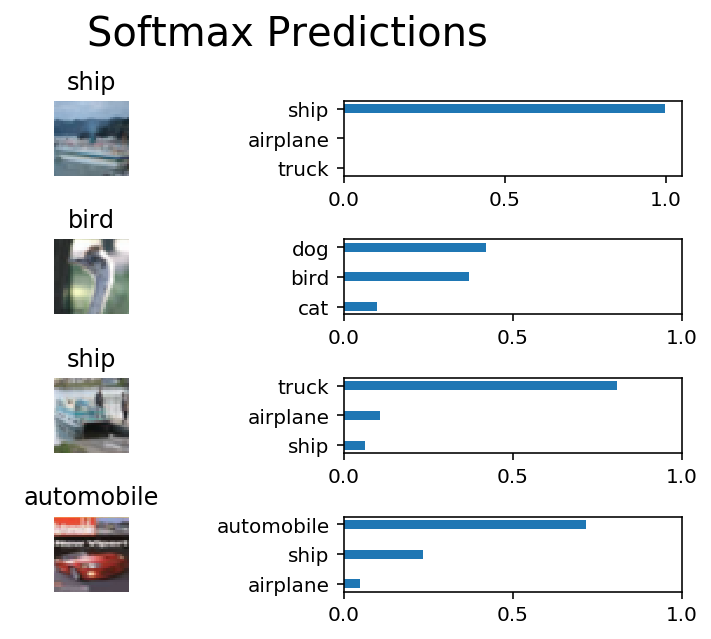

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        loaded_training = loaded_graph.get_tensor_by_name('is_training:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={
                    loaded_x: test_feature_batch,
                    loaded_y: test_label_batch,
                    loaded_keep_prob: 1.0,
                    loaded_training:False
                })
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={
                loaded_x: random_test_features,
                loaded_y: random_test_labels,
                loaded_keep_prob: 1.0,
                loaded_training:False
            })
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()